# Лабораторная работа №2. Анализ контентной стратегии онлайн кинотеатра.

**Преподователь:** Босенко Тимур Муртазович

**Студент:** Шитов Данила Олегович

**Вариант:** №25

**Цель работы:** научиться извлекать данные с веб-страниц, которые подгружают контент динамически с помощью JavaScript. Освоить использование современной библиотеки `Playwright` для управления браузером и языка `XPath` для точного поиска элементов на странице.

**Объект парсинга:** Ivi.ru, раздел "Фильмы" с сортировкой по популярности.

## Часть 1: Теоретические основы XPath

### Что такое XPath?

**XPath (XML Path Language)** — это язык запросов, предназначенный для навигации по элементам и атрибутам в XML и HTML документах. Представьте HTML-страницу как дерево, состоящее из вложенных друг в друга тегов. XPath предоставляет синтаксис, похожий на путь в файловой системе, чтобы точно указать, какой элемент или группу элементов мы хотим найти в этом дереве.

Для веб-скрапинга XPath является мощным инструментом, позволяющим создавать надежные "селекторы" (указатели) для извлечения нужных данных, даже если структура страницы сложная.

### Основной синтаксис XPath

| Выражение | Описание | Пример |
|:---|:---|:---|
| `//` | Выбирает узлы в документе, начиная с текущего, которые соответствуют выбору, где бы они ни находились. | `//table` (найти все таблицы на странице) |
| `tagname` | Выбирает все узлы с заданным именем тега. | `//tr` (найти все строки таблицы) |
| `.` | Выбирает текущий узел. | - |
| `@` | Выбирает атрибуты. | `//button[@name='agree']` (найти кнопку с атрибутом `name`, равным 'agree') |
| `[...]` | Предикат для фильтрации. Позволяет указать точные условия. | `//tr[@data-testid='data-table-v2-row']` (найти строку с атрибутом `data-testid`) |
| `text()` | Выбирает текстовое содержимое узла. | - |
| `contains()` | Функция, которая позволяет искать частичное совпадение текста в атрибуте или содержимом. | `//div[contains(@class, 'table-container')]` (найти div, у которого класс *содержит* 'table-container') |

В нашей практической части мы будем использовать комбинации этих выражений для поиска таблицы и извлечения данных из ячеек.

## Часть 2. Практика - Парсинг Yahoo Finance с помощью Playwright

В этой части мы напишем скрипт, который будет:
1. Управлять браузером Chromium в среде Google Colab с помощью Playwright.
2. Открывать страницу `most-active` на Yahoo Finance.
3. Дожидаться полной загрузки динамической таблицы.
4. Собирать данные об акциях.
5. Сохранять результат в Excel-файл.

In [ ]:
# Шаг 2.1. Установка Playwright и его зависимостей

# Устанавливаем саму библиотеку
!pip install playwright

# Скачиваем браузеры, которыми Playwright будет управлять (в данном случае Chromium)
!playwright install

Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libavif.so.13                                    ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.12/dist-packages/playwright/driver/package/lib/server/registry/dependencies.js:269:9)
    at process.processTicksAndRejections (node:internal/process/task_queues:105

In [146]:
!pip install playwright pandas openpyxl
!playwright install chromium

In [147]:
import asyncio
import aiohttp
from bs4 import BeautifulSoup
import pandas as pd
import random
import nest_asyncio

nest_asyncio.apply()

USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.0 Safari/605.1.15",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; rv:109.0) Gecko/20100101 Firefox/119.0"
]
SEM = asyncio.Semaphore(10)

async def get_html(session, url, retries=3):
    for attempt in range(1, retries + 1):
        try:
            await asyncio.sleep(random.uniform(0.5, 1.5))
            headers = {"User-Agent": random.choice(USER_AGENTS)}
            async with SEM:
                async with session.get(url, headers=headers, timeout=20) as resp:
                    if resp.status == 200:
                        return await resp.text()
                    elif resp.status in (429, 503):
                        await asyncio.sleep(2 ** attempt)
        except Exception:
            await asyncio.sleep(2 ** attempt)
    return None

async def parse_movie_page(session, url):
    html = await get_html(session, url)
    if not html:
        return None
    soup = BeautifulSoup(html, "html.parser")
    container = soup.select_one("ul.paramsList__container")
    anchors = container.select("a.badgeParams") if container else soup.select("a.badgeParams")
    genres = []
    for a in anchors:
        text_div = a.find("div", class_="nbl-textBadge__text")
        if text_div:
            txt = text_div.get_text(strip=True)
            if txt and len(txt) > 2:
                genres.append(txt)
    seen = set()
    clean = []
    for g in genres:
        if g not in seen:
            seen.add(g)
            clean.append(g)
    if clean:
        return ", ".join(clean)
    return None

def parse_page(html, base_url):
    soup = BeautifulSoup(html, "html.parser")
    cards = soup.select("li.gallery__item a[href^='/watch/']")
    data = []
    for c in cards:
        href = c.get("href")
        if not href:
            continue
        url = base_url + href.strip()
        img = c.select_one("img.nbl-poster__image")
        title = img.get("alt") if img else None
        info = c.select_one(".nbl-poster__propertiesInfo")
        year = country = genre = None
        if info:
            parts = [p.strip() for p in info.get_text(strip=True).split(",")]
            if len(parts) > 0:
                year = parts[0]
            if len(parts) > 1:
                country = parts[1]
            if len(parts) > 2:
                genre = parts[2]
        rating_block = c.select_one(".nbl-ratingCompact__value")
        rating = rating_block.get_text(strip=True).replace(",", ".") if rating_block else None
        data.append({
            "Название": title,
            "Год": year,
            "Страна": country,
            "Жанр": genre,
            "Рейтинг": rating,
            "URL": url
        })
    return data

async def parse_ivi():
    base_url = "https://www.ivi.ru"
    urls = [f"{base_url}/movies/{year}/page{page}" for year in range(2025, 2014, -1) for page in range(1, 16)]
    movies = []
    async with aiohttp.ClientSession() as session:
        for i in range(0, len(urls), 10):
            batch = urls[i:i+10]
            html_pages = await asyncio.gather(*[get_html(session, url) for url in batch])
            for html, page_url in zip(html_pages, batch):
                if not html:
                    continue
                page_data = parse_page(html, base_url)
                if page_data:
                    print(f"Обработано: {page_url} — найдено {len(page_data)} фильмов")
                movies.extend(page_data)
        df = pd.DataFrame(movies).drop_duplicates(subset="URL")
        missing_genre = df["Жанр"].isna() | (df["Жанр"].astype(str).str.strip() == "")
        urls_to_update = df.loc[missing_genre, "URL"].tolist()
        urls_to_update = urls_to_update[:100]
        genre_results = await asyncio.gather(*[parse_movie_page(session, u) for u in urls_to_update])
        for url, genre in zip(urls_to_update, genre_results):
            if genre:
                df.loc[df["URL"] == url, "Жанр"] = genre
    df.to_csv("ivi_movies.csv", index=False, encoding="utf-8-sig")
    print("\nФайл сохранён: ivi_movies.csv")
    return df

if __name__ == "__main__":
    asyncio.run(parse_ivi())


Обработано: https://www.ivi.ru/movies/2025/page1 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page2 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page3 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page4 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page5 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page6 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page7 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page8 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page9 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page10 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page11 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page12 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page13 — найдено 27 фильмов
Обработано: https://www.ivi.ru/movies/2025/page14 — найдено 27 фильмов
Обработано: htt

# **Топ 50 фильмов по рейтингу**
(Сортируем по рейтингу, если рейтинг одинаковый по названию)

In [148]:
import re
import pandas as pd
from tabulate import tabulate

file_path = "ivi_movies.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower().str.strip()

mask_season = df.apply(lambda col: col.astype(str).str.contains(r"\bсезон", case=False, na=False))
df = df[~mask_season.any(axis=1)]

if "жанр" in df.columns:
    genres = []
    durations = []
    for value in df["жанр"].astype(str):
        match = re.search(r"(\d+\s*минут[аы]?)", value)
        if match:
            duration = match.group(1).strip()
            genre = value.replace(duration, "").strip()
        else:
            duration = ""
            genre = value.strip()
        genres.append(genre)
        durations.append(duration)
    df["жанр"] = genres
    if "длительность" not in df.columns:
        df.insert(df.columns.get_loc("жанр") + 1, "длительность", durations)
    else:
        df["длительность"] = df["длительность"].fillna("").astype(str)
        df.loc[df["длительность"] == "", "длительность"] = durations

rating_col = None
for col in df.columns:
    if "рейтинг" in col or "rating" in col:
        rating_col = col
        break

if rating_col:
    df = df.sort_values(by=rating_col, ascending=False)

df_top50 = df.head(50)

table = tabulate(
    df_top50,
    headers="keys",
    tablefmt="fancy_grid",
    showindex=range(1, len(df_top50) + 1),
    floatfmt=".2f"
)

print(table)


╒════╤════════════════════════════════════════════════════════════╤═══════╤═══════════╤════════════════╤════════════════╤═══════════╤═══════════════════════════════════════════════════════════╕
│    │ название                                                   │   год │ страна    │ жанр           │ длительность   │   рейтинг │ url                                                       │
╞════╪════════════════════════════════════════════════════════════╪═══════╪═══════════╪════════════════╪════════════════╪═══════════╪═══════════════════════════════════════════════════════════╡
│  1 │ Ласточки Христовы                                          │  2022 │ Россия    │ Документальные │ 70 минут       │      9.20 │ https://www.ivi.ru/watch/486671                           │
├────┼────────────────────────────────────────────────────────────┼───────┼───────────┼────────────────┼────────────────┼───────────┼───────────────────────────────────────────────────────────┤
│  2 │ Каруза                 

# **Визуализация**

In [149]:
import re
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (10, 6)

#Загружаем CSV
file_path = "ivi_movies.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower().str.strip()
mask_season = df.apply(lambda col: col.astype(str).str.contains(r"\bсезон", case=False, na=False))
df = df[~mask_season.any(axis=1)].copy()

#Обрабатываем жанр и длительность ===
if "жанр" in df.columns:
    genres, durations = [], []
    for value in df["жанр"].astype(str):
        match = re.search(r"(\d+\s*минут[аы]?)", value)
        if match:
            duration = match.group(1).strip()
            genre = value.replace(duration, "").strip()
        else:
            duration = ""
            genre = value.strip()
        genres.append(genre)
        durations.append(duration)
    df["жанр"] = genres
    if "длительность" not in df.columns:
        df.insert(df.columns.get_loc("жанр") + 1, "длительность", durations)
    else:
        df["длительность"] = durations

#Преобразуем длительность в числа ===
df["длительность_мин"] = (
    df["длительность"]
    .str.extract(r"(\d+)")
    .astype(float)
)

#Преобразуем рейтинг в числа ===
rating_col = None
for col in df.columns:
    if "рейтинг" in col or "rating" in col:
        rating_col = col
        break
if rating_col:
    df[rating_col] = pd.to_numeric(df[rating_col], errors="coerce")

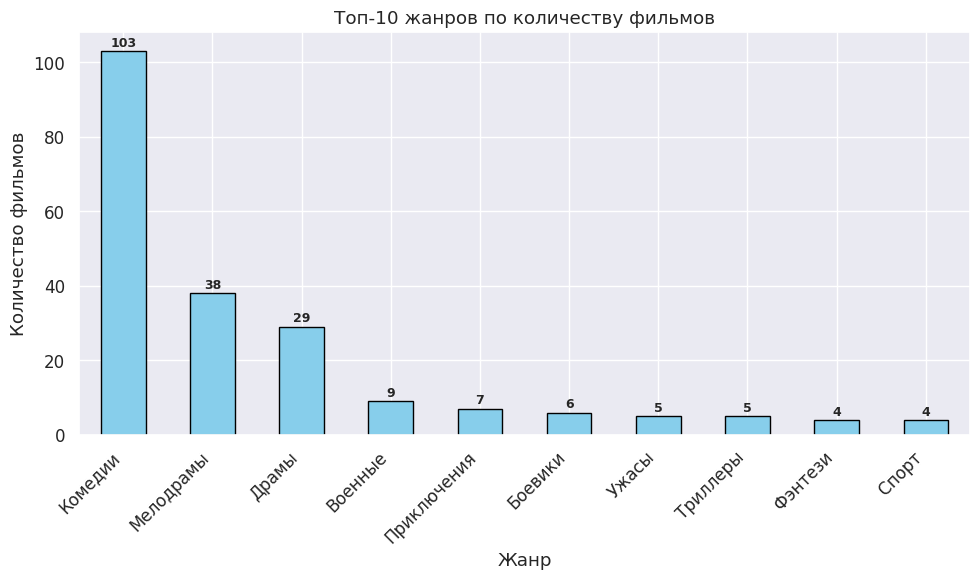

In [150]:
# Рисунок 1 — Топ-10 жанров по количеству фильмов
genre_counts = df["жанр"].value_counts().head(10)
ax = genre_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Топ-10 жанров по количеству фильмов")
plt.xlabel("Жанр")
plt.ylabel("Количество фильмов")
plt.xticks(rotation=45, ha="right")
for i, v in enumerate(genre_counts):
    ax.text(i, v + 0.5, str(int(v)), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


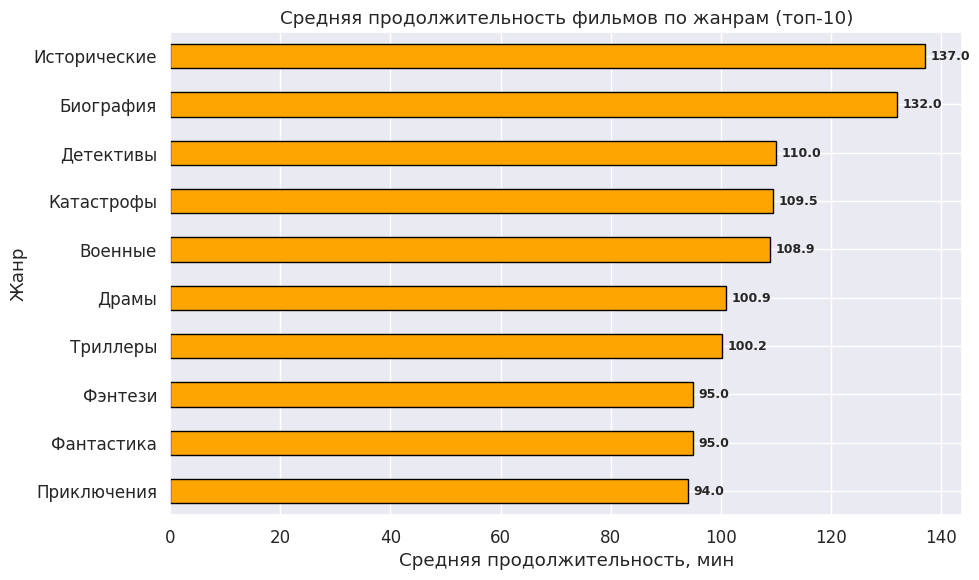

In [151]:
# Рисунок 2 — Средняя продолжительность по жанрам
avg_duration = (
    df.groupby("жанр")["длительность_мин"]
    .mean()
    .dropna()
    .sort_values(ascending=True)
    .tail(10)
)
ax = avg_duration.plot(kind="barh", color="orange", edgecolor="black")
plt.title("Средняя продолжительность фильмов по жанрам (топ-10)")
plt.xlabel("Средняя продолжительность, мин")
plt.ylabel("Жанр")
for i, v in enumerate(avg_duration):
    ax.text(v + 1, i, f"{v:.1f}", va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


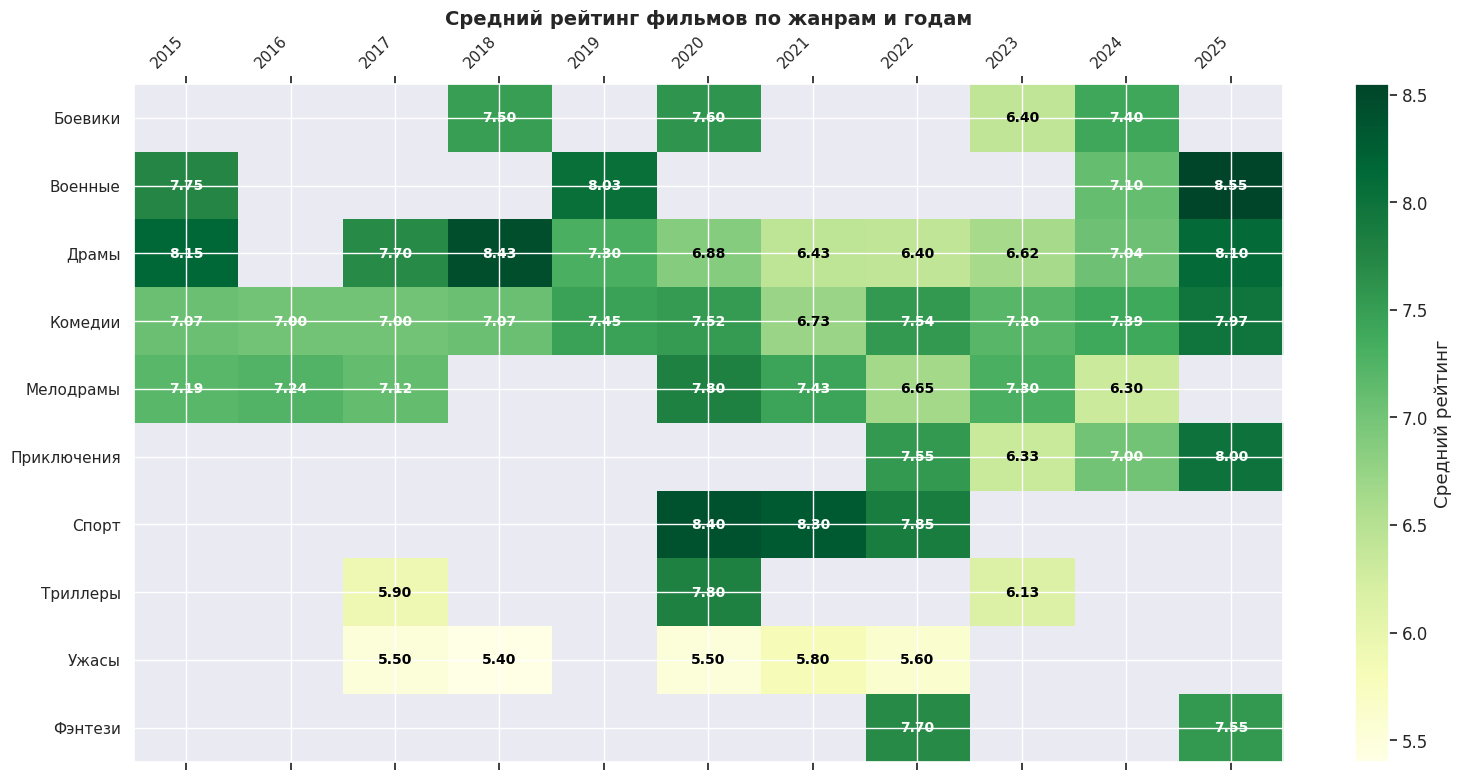

In [152]:
# Рисунок 3 — Тепловая карта ср. рейтинга
import numpy as np
import matplotlib.pyplot as plt

df_plot = df.copy()
df_plot = df_plot.dropna(subset=[rating_col, "жанр", "год"])
df_plot["год"] = pd.to_numeric(df_plot["год"], errors="coerce")
df_plot = df_plot.dropna(subset=["год"])

top_genres = df_plot["жанр"].value_counts().head(10).index.tolist()
df_plot = df_plot[df_plot["жанр"].isin(top_genres)]
pivot_table = df_plot.pivot_table(index="жанр", columns="год", values=rating_col, aggfunc="mean")
fig, ax = plt.subplots(figsize=(16, 8))
cax = ax.matshow(pivot_table, cmap="YlGn", aspect='auto')
ax.set_yticks(range(len(pivot_table.index)))
ax.set_yticklabels(pivot_table.index, fontsize=11)
ax.set_xticks(range(len(pivot_table.columns)))
ax.set_xticklabels(pivot_table.columns, rotation=45, ha="right", fontsize=11)
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        val = pivot_table.iloc[i, j]
        if not np.isnan(val):
            color = 'white' if cax.cmap(cax.norm(val))[0:3] < (0.5, 0.5, 0.5) else 'black'
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=10, fontweight='bold', color=color)

plt.colorbar(cax, label='Средний рейтинг')
plt.title("Средний рейтинг фильмов по жанрам и годам", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


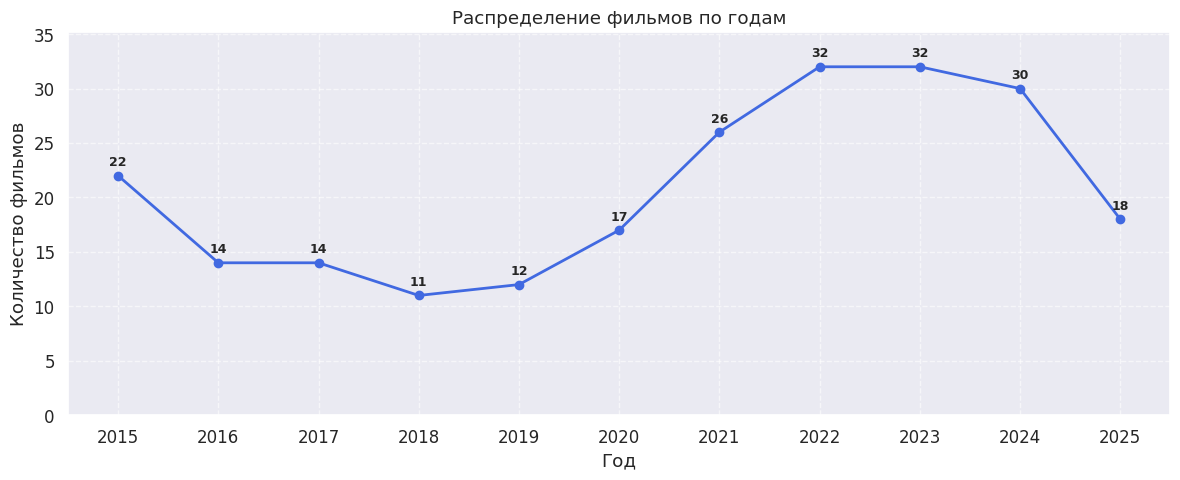

In [153]:
# Рисунок 4 — Распределение фильмов по годам
df["год"] = pd.to_numeric(df["год"], errors="coerce")
films_per_year = df["год"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(films_per_year.index, films_per_year.values, marker="o", color="royalblue", linewidth=2)

plt.title("Распределение фильмов по годам")
plt.xlabel("Год")
plt.ylabel("Количество фильмов")
plt.grid(True, linestyle="--", alpha=0.6)

# добавляем немного пространства сверху
y_max = films_per_year.values.max()
ax.set_ylim(0, y_max * 1.1)

# подписи значений над точками
for x, y in zip(films_per_year.index, films_per_year.values):
    ax.text(x, y + y_max*0.02, str(int(y)), ha="center", va="bottom", fontsize=9, fontweight='bold')

# подписи всех годов на оси X маленьким шрифтом и повернуты
plt.xticks(films_per_year.index, rotation=0, fontsize=12)

plt.tight_layout()
plt.show()


# **Выводы**

# График 1 — Топ-10 жанров по количеству фильмов

Наиболее популярными жанрами среди фильмов на ivi.ru являются Комедии (103 фильма), Мелодрамы (38 фильмов) и Драмы (29 фильмов). Менее представленные жанры в топ-10 — Фэнтези, Спорт, Триллеры и Ужасы, где количество фильмов не превышает 5–6. Зрительская база и контент платформы ориентированы на легкие и эмоционально насыщенные жанры, такие как комедии и драмы.

# График 2 — Средняя продолжительность фильмов по жанрам (топ-10)

Самые длинные фильмы в среднем встречаются в жанрах Исторические (≈137 мин) и Биография (≈132 мин). Жанры, рассчитанные на массового зрителя, например Драмы, Триллеры, Фэнтези, имеют среднюю продолжительность около 95–101 минут. Жанровая специфика сильно влияет на продолжительность фильма: образовательные и исторические жанры требуют больше экранного времени, тогда как популярные массовые жанры создаются более компактными.

# График 3 — Средний рейтинг по фильмам и годам
Самый высокий рейтинг зафиксирован в 2025 году в жанре военные (8,55), следующим результатом следом идет жнр драммы за 2018 год и тройку замыкает триллеры в 2020 году. Это показывает, что популярность и качество фильмов по жанрам меняется со временем, и нет одного года или жанра, который стабильно лидировал бы по рейтингам.

# График 4 — Распределение фильмов по годам
Видно, что начиная с 2018 года кол-во просмотров фильмов на платформе растет и пиковые значения зафиксированы в пост-covid времена, когда уровень и популярность площадки достигла пика. В 2025 году мы видим значительное падение, почти в два раза, что может указывать на снижение интереса аудитории или изменение поведения пользователей.

# **Структура сайта**

**Название** - < h2 class="nbl-blockHeader__titleText">С фильмом «А у нас во дворе.Прерванный сезон» смотрят< div class="nbl-blockHeader__titleArrow">< div class="nbl-iconSvg nbl-blockHeader__arrowItem">< /div>< /div></h2>

**Год** - < a target="_self" class="nbl-link nbl-link_style_wovou" href="/movies/2023">2023< /a>

**Жанр** - < div class="nbl-textBadge__text">Документальные</div>

**рейтинг** - < div class="ratingParamsratingParams_highparamsList__ratingParams">9,1< /div>
**Продолжительность **-  < div data-test="content-duration" class="nbl-link nbl-link_style_wovou nbl-link nbl-link_noLink">1 ч. 43 мин.</div >
